In [2]:
import imageio      #Para leer y guardar imagenes.
import numpy as np  #Operaciones con vectores, matrices, tensores...
import matplotlib.pyplot as plt    #Para realizar graficos.
from numpy import sqrt #necesito la raiz...
import warnings     # (Opcional) Es para evitar algunos mensajes de warning.
warnings.filterwarnings('ignore')

#Para realizar los graficos en la misma linea de codigo.
%matplotlib inline 

In [3]:
#Matriz de transformación para YIQ.
M_YIQ = np.array([[0.299, 0.587, 0.114],
                  [0.595716, -0.274453, -0.321263],
                  [0.211456, -0.522591, 0.311135]])

#Matriz de transformación para RGB.
M_RGB = np.array([[1, 0.9563, 0.6210],
                  [1, -0.2721, -0.6474],
                  [1, -1.1070, 1.7046]])

#Función para operaciones con matrices.
def apply_matrix(img, M):
    return np.matmul(img.reshape((-1,3)), M.T).reshape(img.shape)

#Función simplificada para convertir RGB->YIQ.
def rgb2yiq(img):
    return apply_matrix(img, M_YIQ)

#Función simplificada para convertir YIQ->RGB.
def yiq2rgb(img):
    return apply_matrix(img, M_RGB)

#Función para graficar un histograma.
# -im: imagen de entrada.
# -bins: cantidad de barritas del histograma.
# -ax: el eje donde quiero graficar el histograma (en qué subplot graficarlo).
# -cumulative: grafico acumulado (opcional)
def plot_hist(im, bins, ax, cumulative=False):
    counts, borders = np.histogram(im if im.ndim==2 else rgb2yiq(im)[...,0], bins=bins, range=(0,1))
    ax.bar(range(len(counts)), np.cumsum(counts) if cumulative else counts) #barh para horizontal.
    plt.xticks(ax.get_xticks(), labels=np.round(ax.get_xticks()/bins,2))
    plt.grid(alpha=0.3)

1) Normalizar el histograma al rango [0,1]

(1708, 2560, 3)
MAXIMO:  0.9999999999999999
MINIMO:  0.05484705882352941


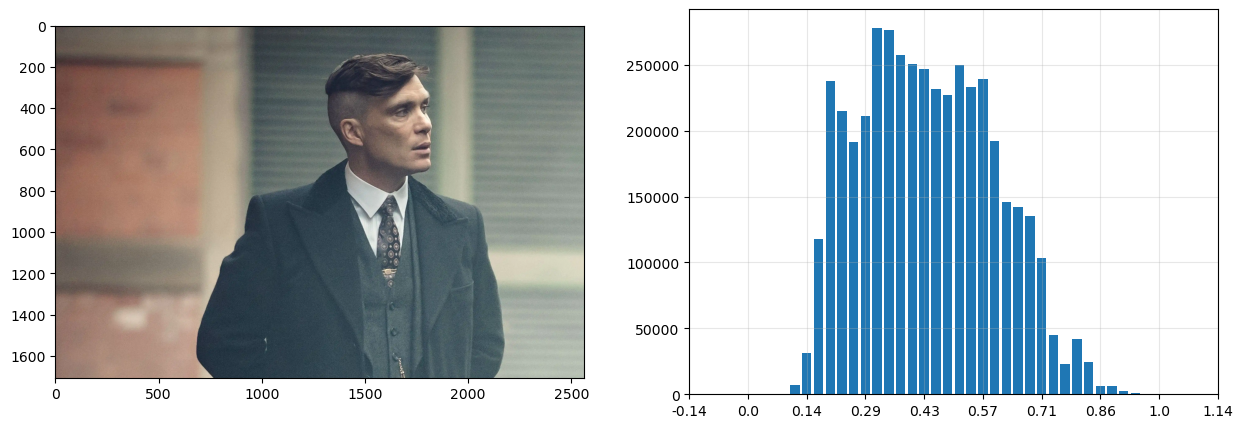

In [4]:
#Cargo una imagen
#img_rgb = imageio.imread('img/paisaje.jpg')/255
img_rgb = imageio.imread('img/tommy.png')/255
print(img_rgb.shape)  #solo lo use para corroborar que tenga ancho alto y los 3 canales (ya q a veces vienen con 4).
img_rgb2yiq = rgb2yiq(img_rgb)
img_rgb2yiq_y = img_rgb2yiq[:,:,0]
print("MAXIMO: ",img_rgb2yiq_y.max())
print("MINIMO: ",img_rgb2yiq_y.min())
#Muestro la imagen con la que voy a trabajar para mejorarla.
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_rgb)
plot_hist(img_rgb, 35, axes[1])

a) Definir una función que normalice el histograma al rango [0,1] Si la imagen es RGB debe normalizar el histograma de luminancias; si es en escala de grises debe normalizar los valores de esa matriz.

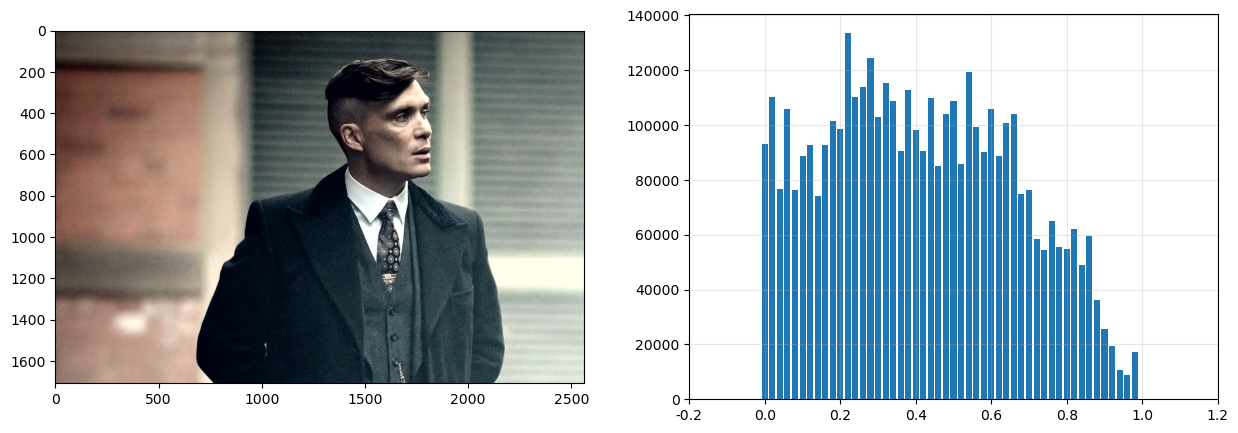

In [5]:
num_filas = len(img_rgb)      # Número de filas
num_columnas = len(img_rgb[0])  # Número de columnas 

#print(num_filas)      
#print(num_columnas)   

#Probé con las funciones sqr() y sqrt() pero no me gustó el resultado, en este caso como la luz está muy alta, habría que usar
#la de sqr(), pero aun asi no me gusto su resultado.
#con lo cual decidí utilizar la función que se encuentra de los slides que se llama "lineal a trozos"
#lo cual estipula 

"""
La forma de implementar esta función es 
por casos:
si Y < Ymín entonces Y’=0 
si Y > Ymáx entonces Y’=1 
caso contrario, realizar interpolación:
"""
#asi que aplicando eso, llegué a un resultado mejor a mi criterio, los colores blancos son más blancos 
#y los colores negros son más negros.
#sin embargo, quedan zonas (el pelo x ej) donde el color negro, se satura, perdiendo informacion en detalles.

val_min = 0.2 
val_max = 0.8


imgyiq = np.zeros(img_rgb.shape)

for i in range(num_filas):
    for j in range(num_columnas):
        Y = img_rgb2yiq[i][j][0]
        I = img_rgb2yiq[i][j][1]
        Q = img_rgb2yiq[i][j][2]

        if Y < val_min:
            imgyiq[i][j][0] = 0
        elif Y > val_max:
            imgyiq[i][j][0] = 1
        else:
            # Interpolación lineal para el caso intermedio
            imgyiq[i][j][0] = (Y - val_min) / (val_max - val_min)

        # Copiar los valores I y Q sin cambios
        imgyiq[i][j][1] = I
        imgyiq[i][j][2] = Q

#vuelvo a rgb
img_final1 = yiq2rgb(imgyiq)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15,5))  #Se plotenan resultados
axes[0].imshow(np.clip(img_final1,0,1))
plot_hist(img_final1, 50, axes[1])

#quedé bastante contento con el resultado, mejoró bastante el "rango dinámico" de la imagen (excluyendo donde saturó).
#se puede apreciar en el histograma que aparece luminancia en intervalos donde no existían o eran ínfimos y se balanceó
#más la imagen.

b) Definir una funcion que normalice el histograma al rango [0,1] usando percentiles, de modo que el pixel del percentil P valga 0, y el pixel del percentil 100-P valga 1. Los valores entre los percentiles 0 y P valdrán 0, y los valores entre los percentiles 100-P y P valdrán 1.

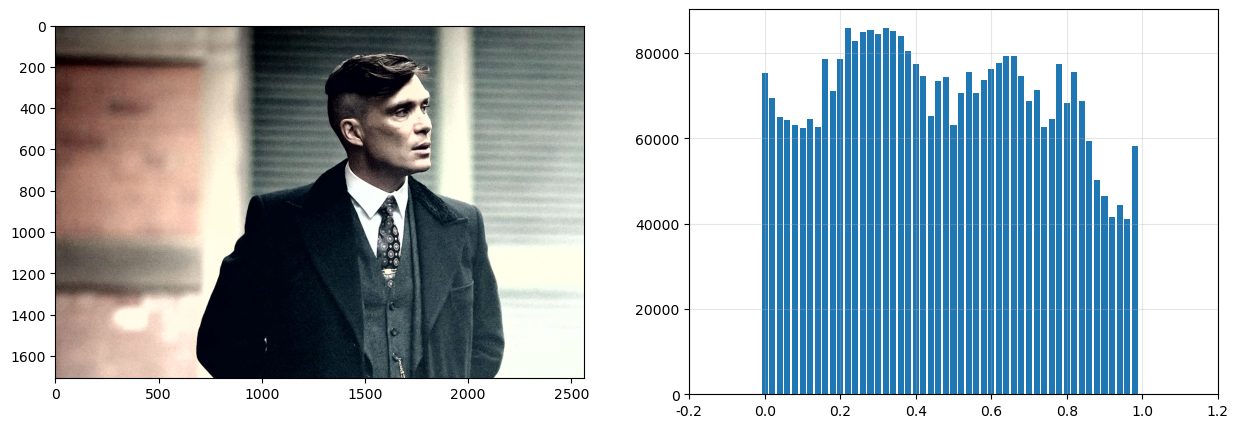

In [8]:
val_min = np.percentile(img_rgb2yiq_y,10) #estuve probando varios valores para el percentil.
val_max = np.percentile(img_rgb2yiq_y,90) #deje estos en específico, por dejar. No tienen ninguna explicación especial.

#el procedimiento es el mismo, solo que con valores fijos previos, se toman los lim_sup y lim_inf con percentiles.

imgyiq = np.zeros(img_rgb.shape)

for i in range(num_filas):
    for j in range(num_columnas):
        Y = img_rgb2yiq[i][j][0]
        I = img_rgb2yiq[i][j][1]
        Q = img_rgb2yiq[i][j][2]

        if Y < val_min:
            imgyiq[i][j][0] = 0
        elif Y > val_max:
            imgyiq[i][j][0] = 1
        else:
            # Interpolación lineal para el caso intermedio
            imgyiq[i][j][0] = (Y - val_min) / (val_max - val_min)

        # Copiar los valores I y Q sin cambios
        imgyiq[i][j][1] = I
        imgyiq[i][j][2] = Q

#vuelvo a rgb
img_final1 = yiq2rgb(imgyiq)

#ploteo
fig, axes = plt.subplots(1, 2, figsize=(15,5))  #Se plotenan resultados
axes[0].imshow(np.clip(img_final1,0,1))
plot_hist(img_final1, 50, axes[1])



2) Corrección del Histograma

a) Aplique la corrección gamma a una imagen. y_out = y_in ^ gamma

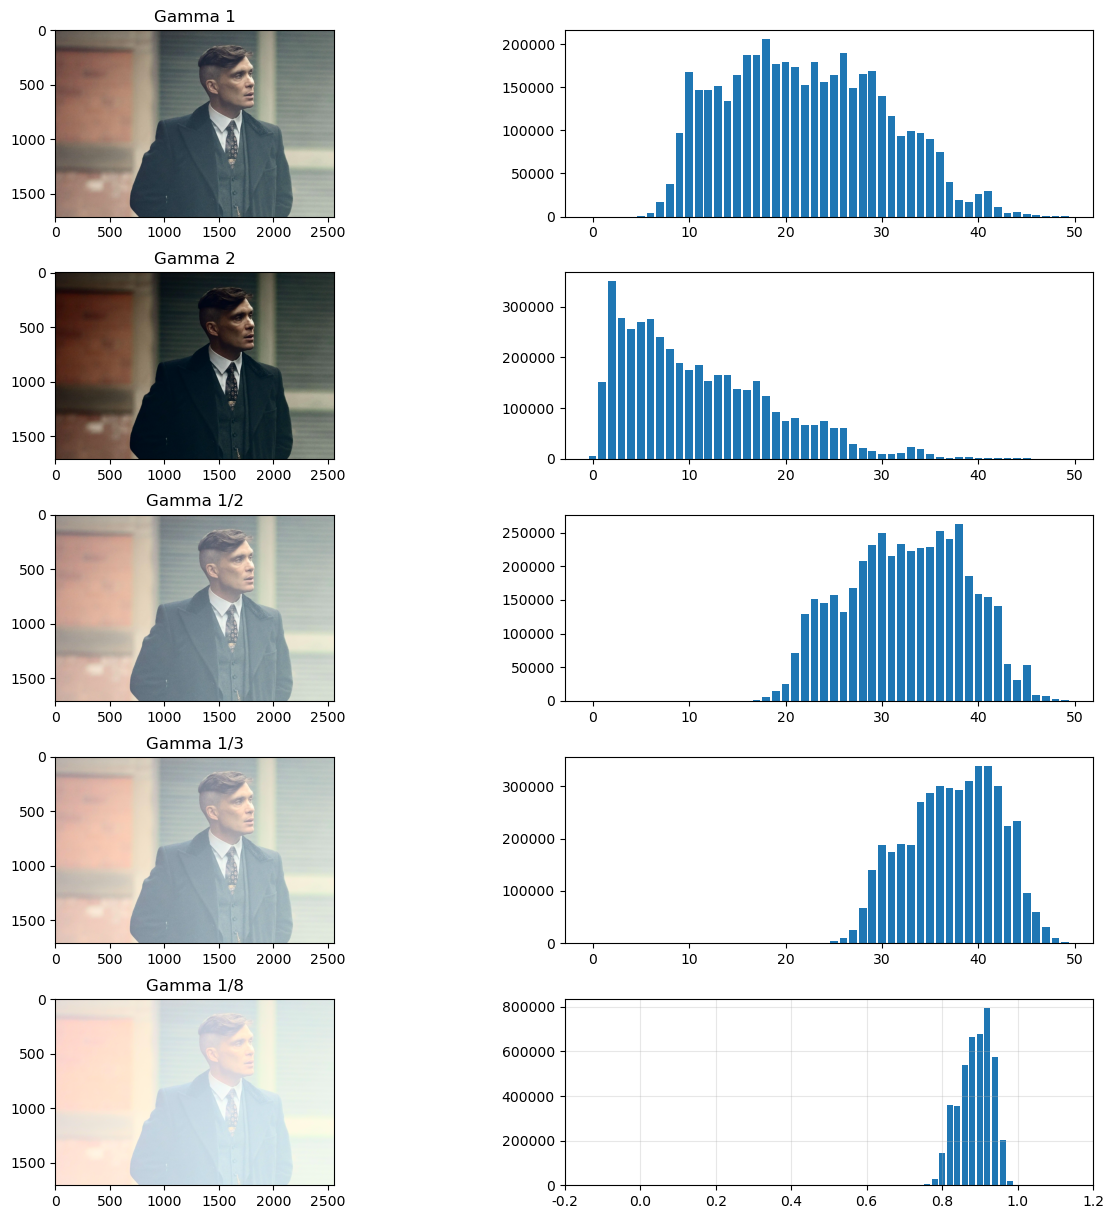

In [20]:
#aqui basicamente defino los valores de gamma que utilizaré.

mgamma1, mgamma2, mgamma05, mgamma033, mgamma0125 = 1, 2, 0.5, 0.33, 0.125

# Inicializo las imágenes que voy a generar.

imggamma1 = img_rgb2yiq.copy()
imggamma2 = img_rgb2yiq.copy()
imggamma05 = img_rgb2yiq.copy()
imggamma033 = img_rgb2yiq.copy()
imggamma0125 = img_rgb2yiq.copy()

#hago la funcion que aplica el gamma.

def cambiarGamma(img, valor_gamma):
    luminancia = img[:, :, 0]
    img[:, :, 0] = np.power(luminancia, valor_gamma)
    return img

# Aplico la corrección gamma.

imggamma1 = cambiarGamma(imggamma1, mgamma1)
imggamma2 = cambiarGamma(imggamma2, mgamma2)
imggamma05 = cambiarGamma(imggamma05, mgamma05)
imggamma033 = cambiarGamma(imggamma033, mgamma033)
imggamma0125 = cambiarGamma(imggamma0125, mgamma0125)

# paso de YIQ a RGB.

img_final_1 = yiq2rgb(imggamma1)
img_final_2 = yiq2rgb(imggamma2)
img_final_05 = yiq2rgb(imggamma05)
img_final_033 = yiq2rgb(imggamma033)
img_final_0125 = yiq2rgb(imggamma0125)

#Muestro las img y los histogramas

fig, axes = plt.subplots(5, 2, figsize=(15,15))
axes[0,0].imshow(np.clip(img_final_1,0,1))
axes[0,0].set_title('Gamma 1')
axes[1,0].imshow(np.clip(img_final_2,0,1))
axes[1,0].set_title('Gamma 2')
axes[2,0].imshow(np.clip(img_final_05,0,1))
axes[2,0].set_title('Gamma 1/2')
axes[3,0].imshow(np.clip(img_final_033,0,1))
axes[3,0].set_title('Gamma 1/3')
axes[4,0].imshow(np.clip(img_final_0125,0,1))
axes[4,0].set_title('Gamma 1/8')
plot_hist(img_final_1, 50, axes[0,1])
plot_hist(img_final_2, 50, axes[1,1])
plot_hist(img_final_05, 50, axes[2,1])
plot_hist(img_final_033, 50, axes[3,1])
plot_hist(img_final_0125, 50, axes[4,1])

plt.subplots_adjust(hspace=0.3) #esto lo pongo xq se me juntaban mucho las img

b) Defina una función que modifique el histograma. Utilice dos arreglos x[ ] e y[ ] que definan una funcion no lineal entre [0,1]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


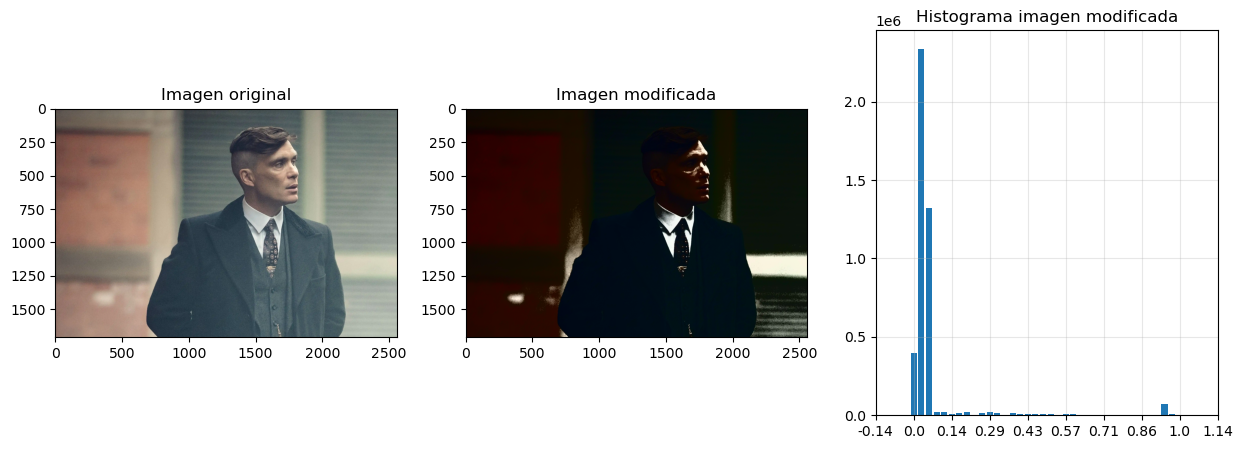

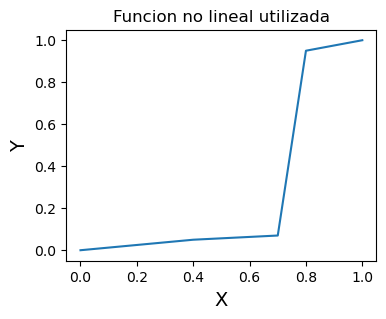

In [35]:
img_yiq = rgb2yiq(img_rgb)
y_channel = img_yiq[:,:,0] 

x = np.linspace(0, 1, 10)  # Genera 10 puntos entre 0 y 1

#Lineal a trozos
x = np.array([0, 0.4, 0.7, 0.8,  1])   #[0 ... 1]
y = np.array([0, 0.05, 0.07, 0.95, 1]) #[0 ... 1]
y_channel_mod = np.interp(y_channel, x, y)

#Vuelvo al espacio RGB
img_yiq[:,:,0] = y_channel_mod
img_rgb_mod2 = yiq2rgb(img_yiq)

#Muestro la imagen modificada
fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(img_rgb)
axes[0].set_title('Imagen original')
axes[1].imshow(img_rgb_mod2)
axes[1].set_title('Imagen modificada')
plot_hist(img_rgb_mod2, 35, axes[2])
axes[2].set_title('Histograma imagen modificada')

#Le seteo un tamaño al grafico
plt.figure(figsize=(4, 3))

#Ploteo los datos
plt.plot(x, y)

#Le cambio parametros a la fuente del plot porq es enorme jaja
plt.title('Funcion no lineal utilizada', fontsize=12)
plt.xlabel('X', fontsize=14)
plt.ylabel('Y', fontsize=14)

#Muestro el grafico
plt.show()